## Power Generation Prediction
We're provided with power and weather data. We're expected to predict power generated over the next 1month. Weather data is also available. 

Table of Contents:
0. Libraries + Dependencies.
1.   Data Exploration and Sanity Checks (Understanding the datasets).
2.   EDA and Time Series Analysis:
    * Univariate Non-graphical EDA.
    * Univariate Graphical EDA.
    * Bivariate Graphical EDA.
    * Multivariate Graphical EDA.
3. Preprocessing:
    * Null values.
    * Outliers.
    * Encoding Categorical Columns.
    * Standardisation/Normalisation.
    * PCA

4. Model Training, Evaluation and Prediction.






            

### Libraries and Dependancies.

In [ ]:
# linear algebra + data processing
import pandas as pd
import numpy as np

# EDA + visualisations
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler


# math/statistics
from scipy.stats import skew, norm
from scipy import stats
from statistics import mean

# modeling
!pip install catboost
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

### 1. Data Exploration and Sanity Checks (Understanding the dataset)

* **datasets:**
    * *actual power data*: 
        * This dataset contains the solar generation of a certain plant from October 1st, 2017 to September 30th, 2019.
        * features: **power, gti** and **ghi**. Power is the actual power generated while GHI (Global Horizontal Irradiance) and GTI (Global Tilt Irradiance) are the parameters relevant to the that define the radiation received from the sun.

    * *actual weather data*: 
        * This dataset contains the weather data of the same plant from October 1st, 2017 to September 30th, 2019.
        * features: **wind gust, wind speed, wind bearing, precipitation probability, precipitation type, datetime, cloud cover, ozone, humidity, temperature**...

    * *forecasted weather data*: 
      * This dataset contains the weather data from October 1st, 2019 to October 27th, 2019. 
      * has same features as the actual weather dataset.

* Merging the first 2 datasets creates our train set. The last dataset serves as our test set (we run predictions on this). The **power** variable in the actual power dataset is our target variable, the weather variables are our predictor variables.

* Other than regression modeling, we're interested in general EDA and TS analysis. 

In [ ]:
# reading the datasets
def read_data(path):
    data = pd.read_csv(path)
    print(f"Dataset dimension: {data.shape[0]} rows, {data.shape[1]} columns.")
    return data

#### power_actual

In [ ]:
power = read_data('/content/drive/MyDrive/power_actual.csv')
# first 5 rows of the power dataset.
power.head()

Dataset dimension: 70080 rows, 5 columns.


Unnamed: 0             datetime  ghi  gti  power
0           0  2017-10-01 00:00:00  0.0  0.0    0.0
1           1  2017-10-01 00:15:00  0.0  0.0    0.0
2           2  2017-10-01 00:30:00  0.0  0.0    0.0
3           3  2017-10-01 00:45:00  0.0  0.0    0.0
4           4  2017-10-01 01:00:00  0.0  0.0    0.0

In [ ]:
# dataset summary
power.describe()

Unnamed: 0      ghi      gti         power
count  70080.000000  35040.0  35040.0  70080.000000
mean   35039.500000      0.0      0.0     28.612915
std    20230.497769      0.0      0.0    498.795887
min        0.000000      0.0      0.0      0.000000
25%    17519.750000      0.0      0.0      0.000000
50%    35039.500000      0.0      0.0      0.000000
75%    52559.250000      0.0      0.0      5.540000
max    70079.000000      0.0      0.0  16172.040000

* **ghi** and **gti** columns each have only one unique value in the entire dataset this renders them useless as they add no information/value thus we have to drop them. 

* **Power** has a high **standard deviation** (coefficient of variation > 1) indicating that the data points are spread out over a large range of values.

In [ ]:
# dropping ghi, gti, and the unnnamed col
power = power.drop(['gti', 'ghi', 'Unnamed: 0'], axis = 1)
power.head(5)

datetime  power
0  2017-10-01 00:00:00    0.0
1  2017-10-01 00:15:00    0.0
2  2017-10-01 00:30:00    0.0
3  2017-10-01 00:45:00    0.0
4  2017-10-01 01:00:00    0.0

#### weather - actual

In [ ]:
actual = read_data('/content/drive/MyDrive/weather_actuals.csv')
actual.head(5)

Dataset dimension: 13619 rows, 31 columns.


Unnamed: 0  plant_id  ... summary           updated_at
0           0         1  ...   Clear  2019-07-16 16:37:16
1           1         1  ...   Foggy  2019-07-16 16:37:16
2           2         1  ...   Foggy  2019-07-16 16:37:16
3           3         1  ...   Clear  2019-07-16 16:37:16
4           4         1  ...   Foggy  2019-07-16 16:37:16

[5 rows x 31 columns]

In [ ]:
# data summary
actual.describe().T

count         mean  ...       75%       max
Unnamed: 0            13619.0  6809.000000  ...  10213.50  13618.00
plant_id              13619.0     1.000000  ...      1.00      1.00
cloud_cover           13619.0  -314.005310  ...      0.41      1.00
apparent_temperature  13619.0    25.944639  ...     34.58     49.75
temperature           13619.0    24.498054  ...     31.00     47.00
humidity              13619.0     0.537411  ...      1.00      1.00
dew_point             13619.0    11.924626  ...     19.67     28.35
wind_bearing          13619.0  -498.677363  ...    293.00    359.00
wind_speed            13619.0  -540.808704  ...      3.33      9.73
wind_chill             3744.0 -9999.000000  ...  -9999.00  -9999.00
wind_gust             13619.0 -2393.184251  ...      4.71     15.15
heat_index             3744.0 -9999.000000  ...  -9999.00  -9999.00
pressure              13619.0  -733.594065  ...   1014.74   1025.69
qpf                    3744.0 -9999.000000  ...  -9999.00  -9999.00
uv_index              13619.0 -2394.989280  ...      2.00     12.00
snow                   3744.0 -9999.000000  ...  -9999.00  -9999.00
pop                    3744.0 -9999.000000  ...  -9999.00  -9999.00
fctcode                3744.0 -9999.000000  ...  -9999.00  -9999.00
ozone                 13619.0 -2187.730797  ...    280.80    351.70
precip_accumulation    3744.0 -9999.000000  ...  -9999.00  -9999.00
precip_intensity      13619.0 -2396.367775  ...      0.00      6.22
precip_probability    13619.0 -2396.398081  ...      0.00      0.73
visibility            13619.0  -117.086149  ...     16.09     16.09

[23 rows x 8 columns]

* A total of 22 columns.
* The following columns have only one unique entry in the entire dataset: **plant_id, precip_accumulation, fctcode, pop, snow, qpf, heat_index, wind_chill** thus we drop them.
* We also drop **datetime_utc** so we can work with the local daytime, and the **untitled column**.
* variation is different across the different features.

In [ ]:
actual = actual.drop(['datetime_utc', 'plant_id', 'precip_accumulation', 'fctcode', 'pop', 'snow', 'qpf', 'heat_index', 'wind_chill', 'Unnamed: 0'], axis = 1)
actual.shape

(13619, 21)

#### weather - forecast

In [ ]:
forecast = read_data('/content/drive/MyDrive/weather_forecast.csv')
forecast.head()

Dataset dimension: 648 rows, 31 columns.


Unnamed: 0  plant_id  ...        summary           updated_at
0           0         1  ...  Partly Cloudy  2019-10-02 23:32:38
1           1         1  ...  Partly Cloudy  2019-10-02 23:32:38
2           2         1  ...  Partly Cloudy  2019-10-02 23:32:38
3           3         1  ...  Partly Cloudy  2019-10-02 23:32:38
4           4         1  ...  Partly Cloudy  2019-10-02 23:32:38

[5 rows x 31 columns]

In [ ]:
forecast.describe()

Unnamed: 0  plant_id  ...  precip_probability    visibility
count  648.000000     648.0  ...          648.000000  6.480000e+02
mean   323.500000       1.0  ...            0.002423  1.609000e+01
std    187.205769       0.0  ...            0.006543  1.102192e-13
min      0.000000       1.0  ...            0.000000  1.609000e+01
25%    161.750000       1.0  ...            0.000000  1.609000e+01
50%    323.500000       1.0  ...            0.000000  1.609000e+01
75%    485.250000       1.0  ...            0.000000  1.609000e+01
max    647.000000       1.0  ...            0.060000  1.609000e+01

[8 rows x 23 columns]

* observation similar to that of weather actuals, so similar steps are undertaken here.

In [ ]:
forecast = forecast.drop(['datetime_utc', 'plant_id', 'precip_accumulation', 'fctcode', 'pop', 'snow', 'qpf', 'heat_index', 'wind_chill', 'Unnamed: 0'], axis = 1)
forecast.shape

(648, 21)

### 2. EDA and Time Series Analysis.

> Like mentioned earlier: we generate our train set by merging the power and actual_weather datasets. By doing so, some data is lost because entries in the power data have 15mins time intervals while entries in the actual weather dataset have 1hr time intervals. Regardless, we merge the 2 on the weather data datetime, and perform no aggregation since power recorded at a particular time is instantaneous.

In [ ]:
''' merging actual and power on datetime column.'''

# cooonverting the datetime cols to datetime data type.
power['datetime'] = pd.to_datetime(power.datetime)
actual['datetime_local'] = pd.to_datetime(actual.datetime_local)

# performing a left join
train  = pd.merge(left=actual, right=power, how='left', left_on='datetime_local', right_on='datetime')

# recording entries with -9999 as null values
train.replace(-9999,np.NaN, inplace = True)
train.replace('-9999',np.NaN, inplace = True)

# the shape and the head of the merged dataset.
print(train.shape)
train.head()

(13619, 23)


datetime_local  cloud_cover  ...            datetime  power
0 2017-10-01 00:00:00          0.0  ... 2017-10-01 00:00:00    0.0
1 2017-10-01 01:00:00          0.0  ... 2017-10-01 01:00:00    0.0
2 2017-10-01 02:00:00          0.0  ... 2017-10-01 02:00:00    0.0
3 2017-10-01 03:00:00          0.0  ... 2017-10-01 03:00:00    0.0
4 2017-10-01 04:00:00          0.0  ... 2017-10-01 04:00:00    0.0

[5 rows x 23 columns]

#### Univariate non-graphical

> Involves calculation of spread, measures of central tendency among other summaries without using graphical presentations.

In [ ]:
# train data information: columns, datatypes, complete values. 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13619 entries, 0 to 13618
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime_local        13619 non-null  datetime64[ns]
 1   cloud_cover           13191 non-null  float64       
 2   apparent_temperature  13619 non-null  float64       
 3   temperature           13619 non-null  int64         
 4   humidity              13619 non-null  int64         
 5   dew_point             13619 non-null  float64       
 6   wind_bearing          12700 non-null  float64       
 7   wind_speed            12879 non-null  float64       
 8   wind_gust             10355 non-null  float64       
 9   pressure              11463 non-null  float64       
 10  uv_index              10355 non-null  float64       
 11  ozone                 10355 non-null  float64       
 12  precip_intensity      10355 non-null  float64       
 13  precip_probabili

> Dataset has numeric (float, int), categorical (object) and timestamp(datetime) features.

> Some features like precip_type, visibility, ... have missing values. 

In [ ]:
train.describe().T

count         mean  ...       75%       max
cloud_cover           13191.0     0.237562  ...     0.430      1.00
apparent_temperature  13619.0    25.944639  ...    34.580     49.75
temperature           13619.0    24.498054  ...    31.000     47.00
humidity              13619.0     0.537411  ...     1.000      1.00
dew_point             13619.0    11.924626  ...    19.670     28.35
wind_bearing          12700.0   188.786929  ...   298.000    359.00
wind_speed            12879.0     2.638890  ...     3.400      9.73
wind_gust             10355.0     4.245261  ...     5.340     15.15
pressure              11463.0  1009.074974  ...  1015.625   1025.69
uv_index              10355.0     1.871270  ...     3.000     12.00
ozone                 10355.0   274.459707  ...   283.900    351.70
precip_intensity      10355.0     0.058259  ...     0.010      6.22
precip_probability    10355.0     0.018400  ...     0.010      0.73
visibility            13443.0    12.290986  ...    16.090     16.09
power                 13619.0    35.255627  ...     5.810  15504.75

[15 rows x 8 columns]

In [ ]:
pd.DataFrame([train.skew(), train.kurtosis()], index = ['skewness', 'kurtosis'])

cloud_cover  apparent_temperature  ...  visibility       power
skewness     1.175080              0.048117  ...   -1.057062   20.065721
kurtosis    -0.168541             -1.013710  ...   -0.831659  432.858660

[2 rows x 15 columns]

* **Highly skewed distribution**: If the skewness value is less than −1 or greater than +1.

* **Moderately skewed distribution**: If the skewness value is between −1 and −½ or between +½ and +1.

* **Approximately symmetric distribution**: If the skewness value is between −½ and +½.

* **Really Flat distribution**: Kurtosis less than -1. Peaked distribution: Kurtosis more than 1.

> Distribution plots in the next section will confirm these observations.


#### Univariate Graphical

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

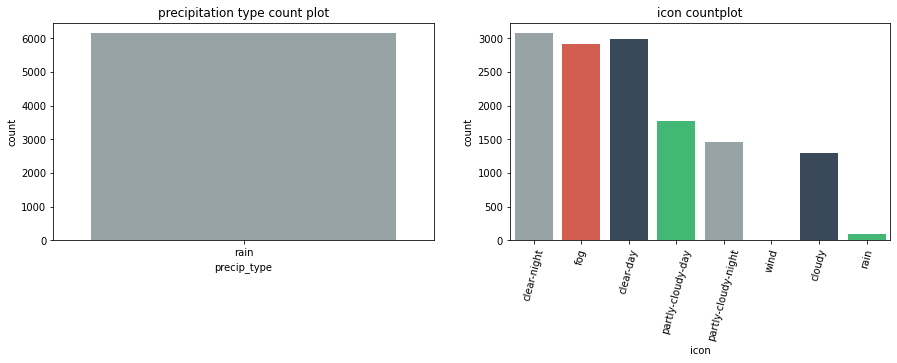

In [ ]:
# categorical features countplots
plt.figure(figsize = (8,6))
sns.countplot(x='summary', data=train, palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]).set_title('a count plot of summary')
plt.xticks(rotation = 75)
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.countplot(x='precip_type', data=train, ax=axis1, palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]).set_title('precipitation type count plot')
sns.countplot(x='icon', data=train, ax=axis2, palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]).set_title('icon countplot')
plt.xticks(rotation = 75)

* **precip_type** has one unique entry, and null values too, so we'll drop this. 

* **icon** and **summary**  have more than one unique values, thus we'll see later how they cause variation.

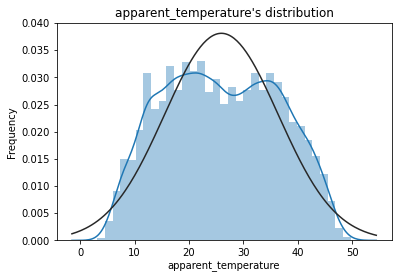

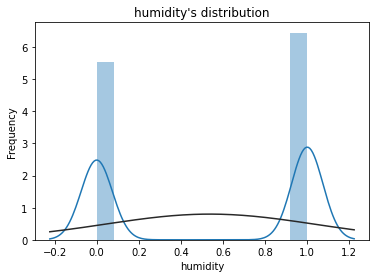

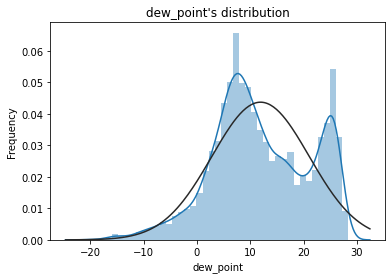

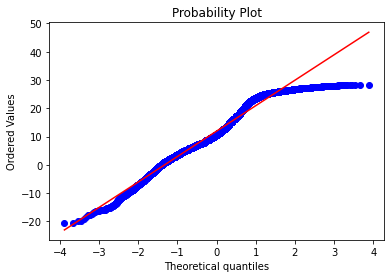

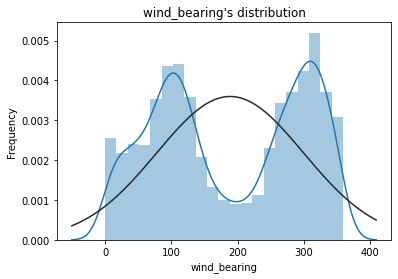

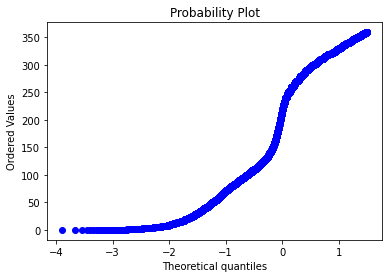

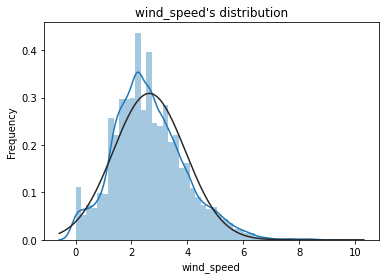

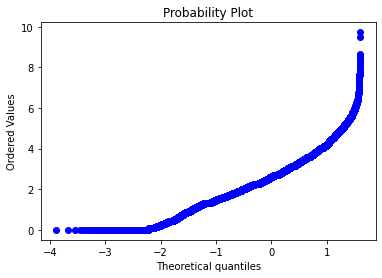

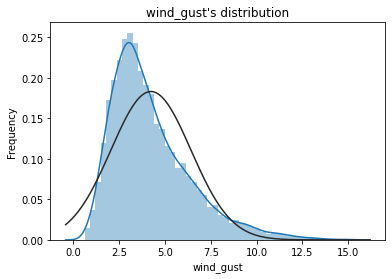

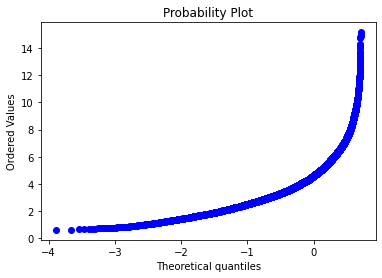

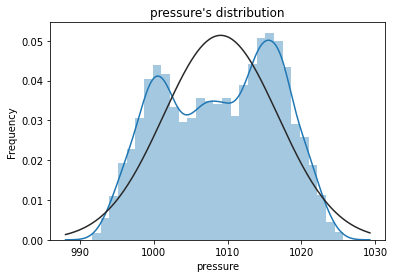

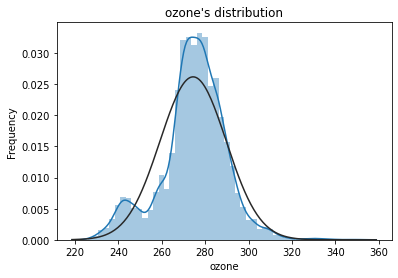

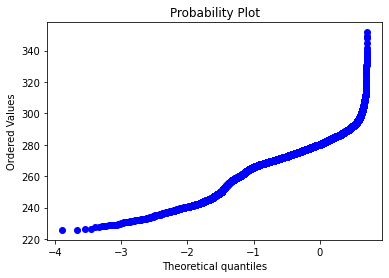

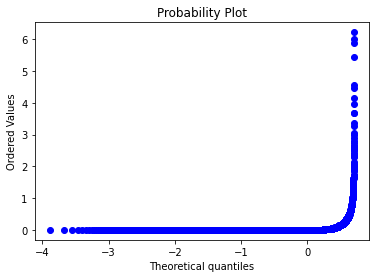

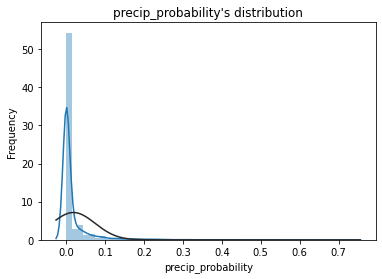

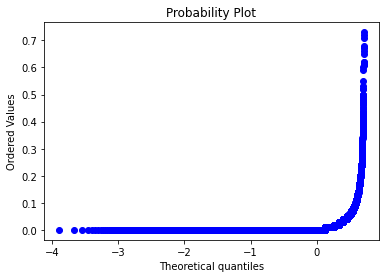

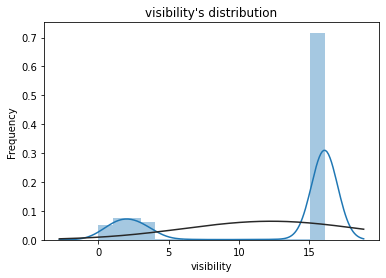

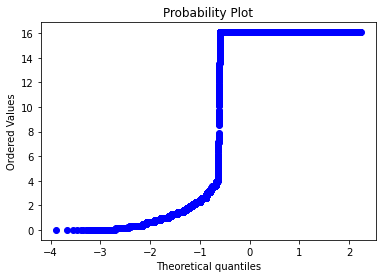

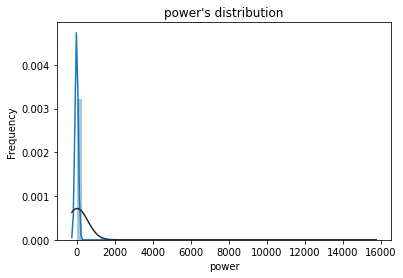

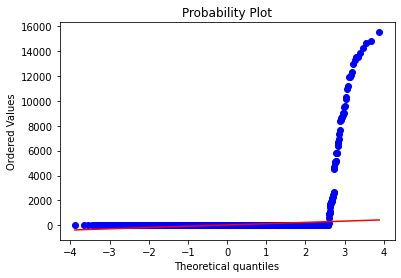

In [ ]:
# distributions plots (histograms and qqplots.)
def dist_plt(data, feature):
    sns.distplot(data[feature] , fit=norm);

    plt.ylabel('Frequency')
    plt.title(f"{feature}'s distribution")

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(data[feature], plot=plt)
    plt.show()

numerical_features = []
for col in train.columns:
    if train[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)

for col in numerical_features:
    dist_plt(train, col)

* Unimodal Normal distribution:
    * **Symmetric**: A histogram is symmetric if you cut it down the middle and the left-hand and right-hand sides resemble mirror images of each other.

    * **Skewed right**: A skewed right histogram looks like a lopsided mound, with a tail going off to the right. e.g **wind_gust**

    * **Skewed left**: If a histogram is skewed left, it looks like a lopsided mound with a tail going off to the left: ****

* Multimodal Distribution: Histogram has more than one peak e.g **wind_bearing**

* Uniform distribution: Histogram has no peaks/ flat top.

> These plots align with the observations from skewness and kurtosis.

#### Bivariate Graphical

> Exploring relationships between 2 variables using plots.

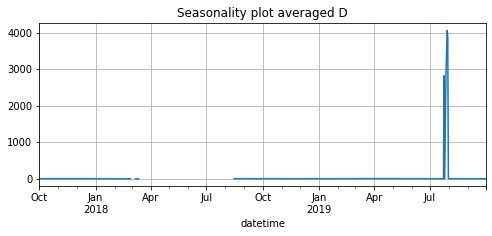

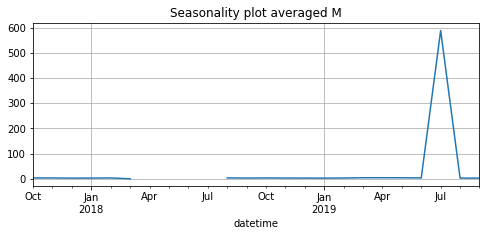

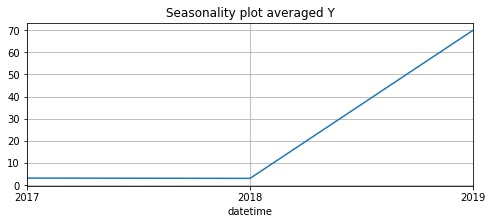

In [ ]:
# Trend? Seasonality? in power generation.

# time/power dataset
time_data = train[['datetime_local', 'power']]
time_data['datetime'] = pd.to_datetime(time_data['datetime_local'])
time_data = time_data.set_index('datetime')
time_data = time_data.drop(['datetime_local'], axis = 1)

# ts plot
def seasonality_plot(data, feature, time_agg):
    df = data[feature].resample(time_agg).mean()
    plt.figure(figsize = (8,3))
    plt.title(f'Seasonality plot averaged {time_agg}')
    df.plot()
    plt.grid()
    plt.show()

# daily train
seasonality_plot(time_data, 'power', 'D')

# Monthly train
seasonality_plot(time_data, 'power', 'M')

# yearly train
seasonality_plot(time_data, 'power', 'Y')

> There's no particular trend nor seasonality.

> There's missing/no records for March-Aug 2018.

> Power generation peaks in the month of July 2019.

> Power generation is higher in 2019 than in 2018, ~ cause of the July peak.

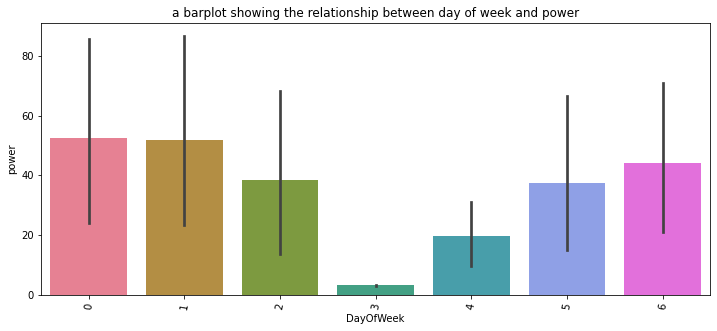

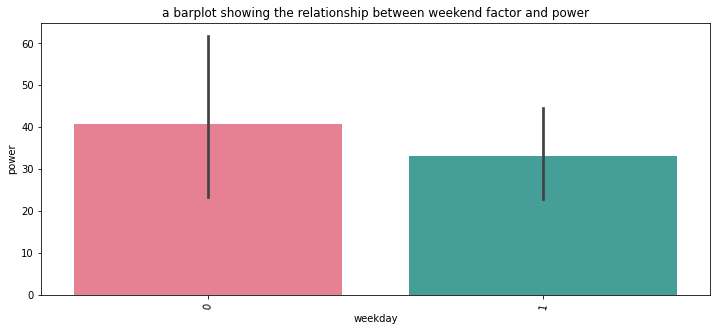

In [ ]:
train['DayOfWeek'] = train.datetime_local.dt.dayofweek.to_list()
train['weekday'] = 1        # Initialize the column with default value of 1
train.loc[train['DayOfWeek'] == 5, 'weekday'] = 0
train.loc[train['DayOfWeek'] == 6, 'weekday'] = 0

# day of week power generation
plt.figure(figsize = (12, 5))
sns.barplot(x = train['DayOfWeek'], y = train['power'], palette = 'husl')
plt.xticks(rotation = 80)
plt.title('a barplot showing the relationship between day of week and power')
plt.show()

# weekend factor
plt.figure(figsize = (12, 5))
sns.barplot(x = train['weekday'], y = train['power'], palette = 'husl')
plt.xticks(rotation = 80)
plt.title('a barplot showing the relationship between weekend factor and power')
plt.show()

> Power production is higher during the weekends than on weekdays.

> Power generation is lowest on Thursday, from where it starts increasing till Monday when it flattens then starts reducing from Wednesay.

In [ ]:
# summary vs power
plt.figure(figsize = (12, 5))
sns.barplot(x = train['summary'], y = train['power'], palette = 'husl')
plt.xticks(rotation = 80)
plt.title('a barplot showing the relationship between summary and power')

Text(0.5, 1.0, 'a barplot showing the relationship between summary and power')

Most of the summaries are associate with very low to 0 power generation apart from when it is: **humid and partly cloudy, humid and mostly cloudy, humif and overcast, possible light rain and humid, humid**. **Humidity** is the constant in all the cases thus must greatly affect power generation. 

In [ ]:
# icon vs power
plt.figure(figsize = (12, 5))
sns.barplot(x = train['icon'], y = train['power'], palette = 'husl')
plt.xticks(rotation = 80)
plt.title('a barplot showing the relationship between icon and power')

Text(0.5, 1.0, 'a barplot showing the relationship between icon and power')

> Just like the case in summary, most icons are associated with very low to 0 power generation, apart from: **clear_days, partly cloudy days, cloudy and rainy days**. **Cloud** is the constant in this case. 

>Also observe that we also have rain, a rainy day indicates a humid day, a cloudy day indicates a humid day (clody day ~ not sosunny ~ low rates of evaporation ~ atmospheric moitur retention), thus humidity and cloud cover play important roles in power generatttion.

> We'll see this in features importance during modeling.

Text(0.5, 1.0, 'a barplot showing the relationship between summary and humidity')

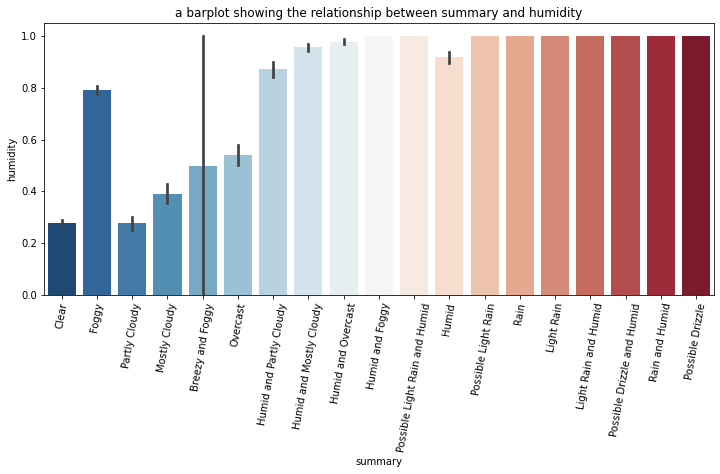

In [ ]:
# summary vs humidity
plt.figure(figsize = (12, 5))
sns.barplot(x = train['summary'], y = train['humidity'], palette = 'RdBu_r')
plt.xticks(rotation = 80)
plt.title('a barplot showing the relationship between summary and humidity')

Most of the summaries have a uniform high humidity levels of around 0.9 except for a few associated with low humidity e.g when its **clear, partly cloudy, mostly cloudy** and **overcast** 

#### Multivariate Graphical

Exploring relationships between more than 2 variables using plots.

top 20 features with highest correlation with sales


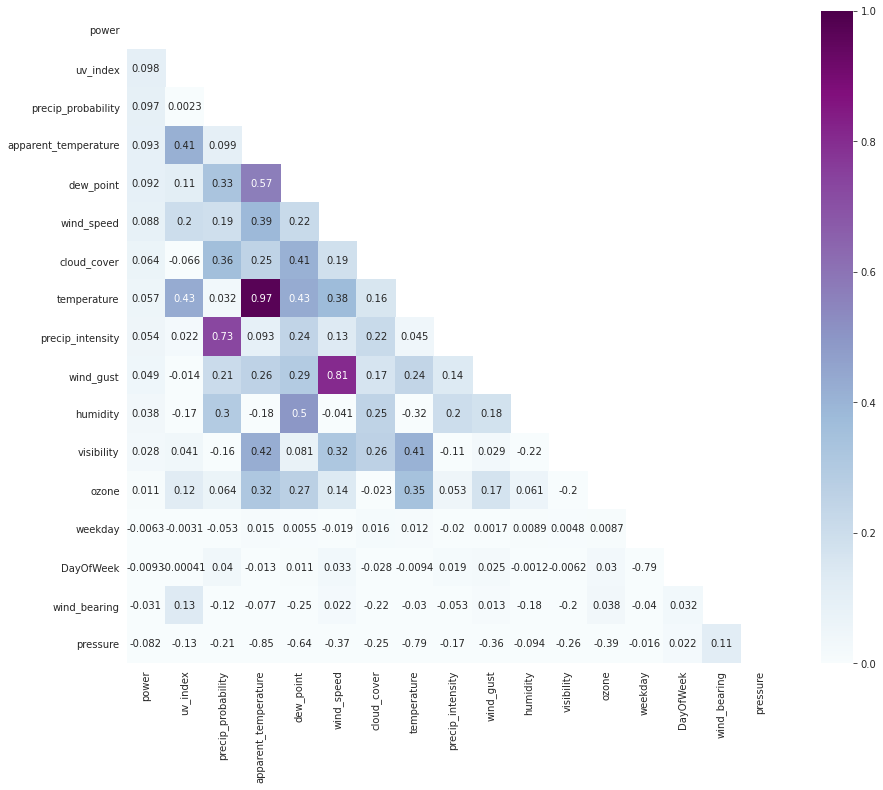

In [ ]:
# correlation
def correlation_map(f_data, f_feature, f_number):
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(15, 12))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

print('top 20 features with highest correlation with sales')
correlation_map(train, 'power', 20)

> The weather features are not correlated with power. Interesting. 

> But some features have a high correlation with each other e.g: **temperature** and **apparent_temmperature**, **wind speed and wind gust**, **precipitation intensity and precipitation probability**.

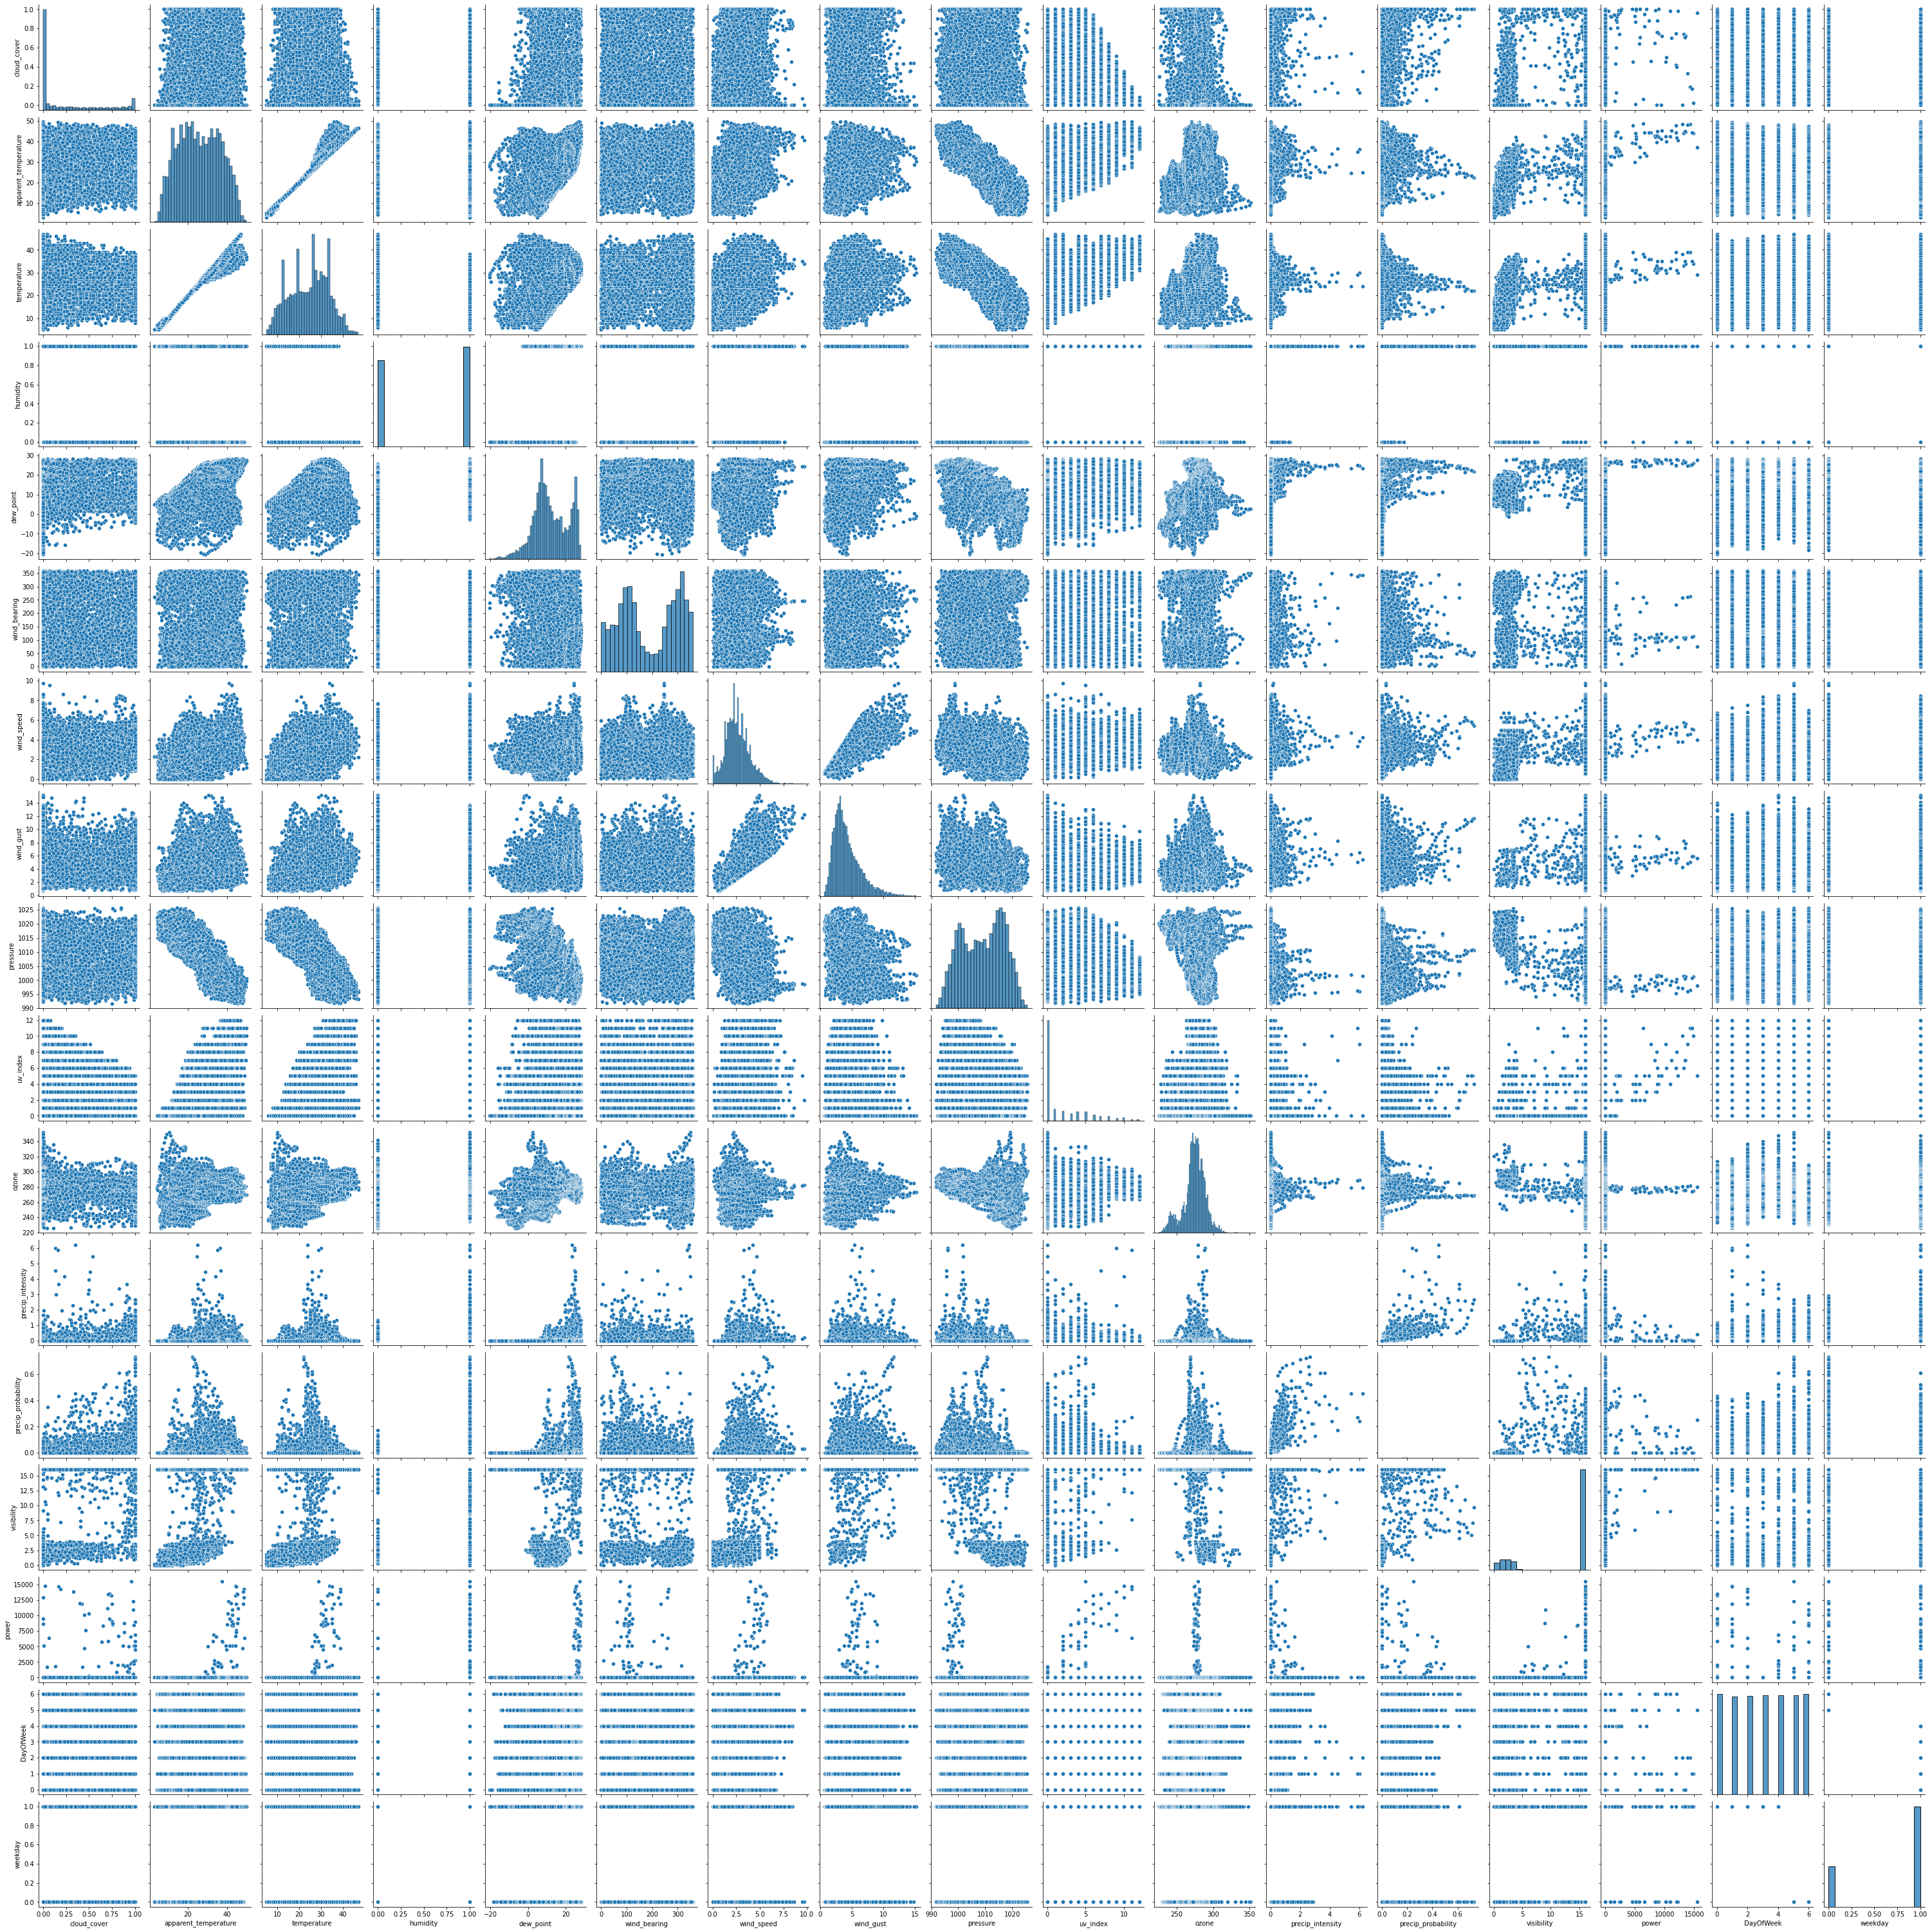

In [ ]:
# pairplot
sns.pairplot(train)

> Scatter plots of all possible bivariate combinations. Some plots indicate linear relationships between variables, others indicate variables with only 2 possibilities, some indicate randomness (no particular relationship).

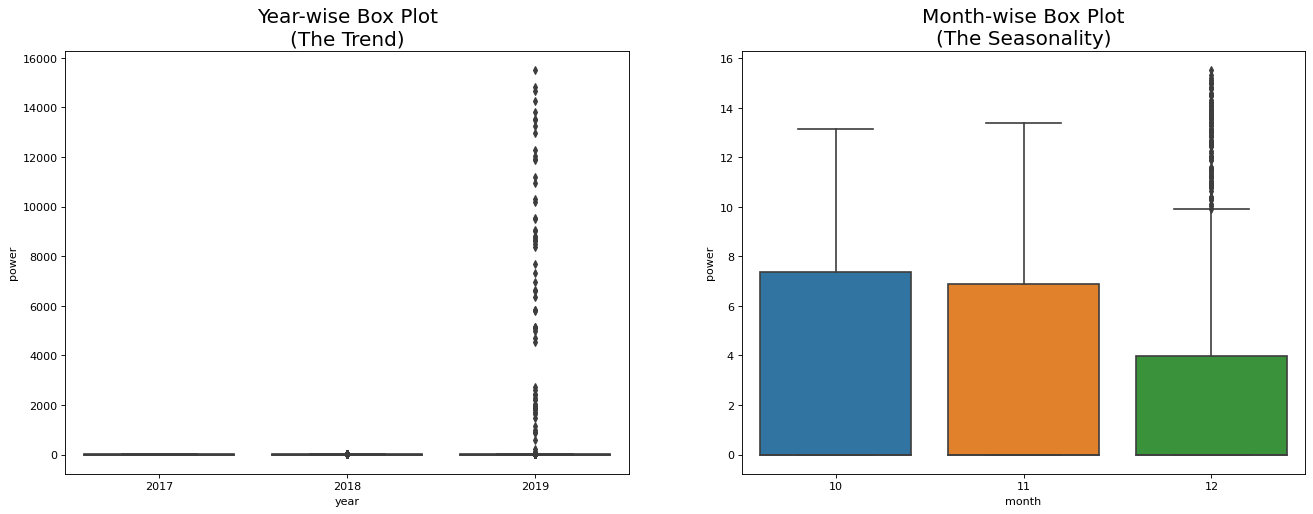

In [ ]:
train['month'] = train.datetime_local.dt.month.to_list()
train['year'] = train.datetime_local.dt.year.to_list()

# time series box plots
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='power', data=train, ax=axes[0])
sns.boxplot(x='month', y='power', data=train.loc[~train.year.isin([2018, 2019]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

> The 2019 boxplot behaviour can be explained by the July peak which surely looks like an 'outlier'. 

### 3. Preprocessing

Before the modeling phase, we have to preprocess both our train and test sets. For uniform preprocessing, we concatenate the train features (==weather_actual dataset) with the test data set (==weather forecast).

In [ ]:
# concat train features and test sets for uniform preprocessing

# set aside the target variable
train_target = train[['power']]

# concated dataset
data = pd.concat([actual, forecast])

# recording entries with -9999 as null values
data.replace(-9999,np.NaN, inplace = True)
data.replace('-9999',np.NaN, inplace = True)
data.shape

(14267, 21)

In [ ]:
# some feature extraction before heading to preprocessing
data['datetime_local'] = pd.to_datetime(data.datetime_local)
data['Month'] = data.datetime_local.dt.month.to_list()
data['WeekOfYear'] = data.datetime_local.dt.weekofyear.to_list()
data['Year'] = data.datetime_local.dt.year.to_list()
data['DayOfWeek'] = data.datetime_local.dt.dayofweek.to_list()
data['weekday'] = 1        # Initialize the column with default value of 1
data.loc[data['DayOfWeek'] == 5, 'weekday'] = 0
data.loc[data['DayOfWeek'] == 6, 'weekday'] = 0

data.shape

(14267, 26)

#### Null Values

> We handle null values before modeling in order to attain robust models at the end.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

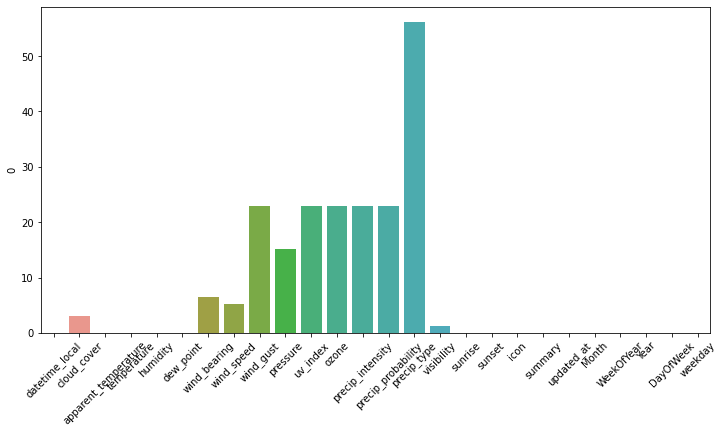

In [ ]:
null = pd.DataFrame(((data.isna().sum())/data.shape[0])*100)
plt.figure(figsize = (12,6))
sns.barplot(x = null.index, y = null.iloc[:, -1])
plt.xticks(rotation = 45)

* **precip_type** - more than half of its enntries are missingg. It's also not among the top 20 features most correlated with *power* thus droping it isn't a very big loss. It is also missing in the test set, thus imputation will result to highly inaccurate data.

* **cloud_cover, wind_bearing, wind_speed, wind_gust, pressure, uv_index, ozone, precip_intensity, precip probability** - Their missing entries are less than 25% of the entire column, thus imputation is the best approach.

In [ ]:
data = data.drop(['precip_type'], axis = 1)
data.shape

(14267, 25)

wind_speed  wind_gust  wind_bearing  temperature  pressure
wind_speed      1.000000   0.805146      0.031979     0.370134 -0.366439
wind_gust       0.805146   1.000000      0.016286     0.227654 -0.356187
wind_bearing    0.031979   0.016286      1.000000    -0.029211  0.104717
temperature     0.370134   0.227654     -0.029211     1.000000 -0.780897
pressure       -0.366439  -0.356187      0.104717    -0.780897  1.000000

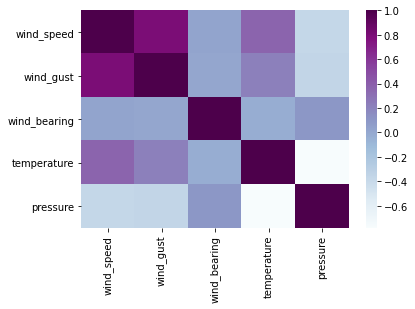

In [ ]:
# correlation between the wind features:
wind_feat = data[['wind_speed', 'wind_gust', 'wind_bearing', 'temperature', 'pressure']]
sns.heatmap(wind_feat.corr(), cmap = 'BuPu')
wind_feat.corr()

* **wind_speed** and **wind_gust** are the only highly correlated features, thus regression imputation may not be the best imputation method given they both have missing features.
* Now going feature by feature:

    * **wind_speed, 'wind_bearing, wind_gust, ozone, cloud_coverage, uv_index, precip_intensity, precip probability, visibility** - impute using weekly mean.
    * **pressure** - Regression interpolation - (correlation with temperature). 

temperature  pressure  humidity  dew_point
temperature     1.000000 -0.780897 -0.332664   0.429107
pressure       -0.780897  1.000000 -0.088351  -0.629507
humidity       -0.332664 -0.088351  1.000000   0.492183
dew_point       0.429107 -0.629507  0.492183   1.000000

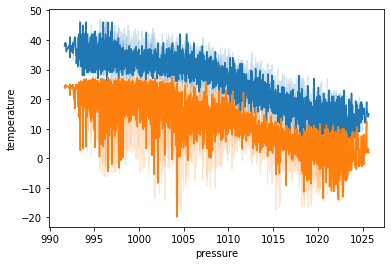

In [ ]:
press_feat = data[['temperature', 'pressure', 'humidity', 'dew_point']]
sns.lineplot(x = data['pressure'], y = data['temperature'])
sns.lineplot(x = data['pressure'], y = data['dew_point'])
press_feat.corr()

In [ ]:
# weekly means imputation
def week_mean_impute(data, feature, time_agg):
    filler = data.groupby([time_agg])[feature].mean()
    filler = pd.DataFrame(filler.fillna(method='ffill'),columns=[feature])
    filler_dict = filler.to_dict()
    map = filler_dict[feature]

    data[feature] = data[feature].fillna(data[time_agg].map(map))


for feature in ['visibility', 'wind_speed', 'wind_gust', 'wind_bearing', 'ozone', 'cloud_cover', 'uv_index', 'precip_intensity', 'precip_probability']:
    week_mean_impute(data, feature, 'WeekOfYear')

data.isna().sum()

datetime_local             0
cloud_cover                0
apparent_temperature       0
temperature                0
humidity                   0
dew_point                  0
wind_bearing               0
wind_speed                 0
wind_gust                  0
pressure                2156
uv_index                   0
ozone                      0
precip_intensity           0
precip_probability         0
visibility                 0
sunrise                    0
sunset                     0
icon                       0
summary                    0
updated_at                 0
Month                      0
WeekOfYear                 0
Year                       0
DayOfWeek                  0
weekday                    0
dtype: int64

In [ ]:
# regression imputation
press_train = data.loc[train.pressure.notna()]
press_test = data.loc[train.pressure.isna()]
press_train = press_train[['temperature', 'pressure']]
press_test = press_test[['temperature']]
press_train.shape, press_test.shape


press = data[['temperature', 'pressure', 'dew_point']]
imputer = IterativeImputer(BayesianRidge())
press = pd.DataFrame(imputer.fit_transform(press))

data['pressure'] = press.iloc[:, 1]
data.isna().sum()

datetime_local          0
cloud_cover             0
apparent_temperature    0
temperature             0
humidity                0
dew_point               0
wind_bearing            0
wind_speed              0
wind_gust               0
pressure                0
uv_index                0
ozone                   0
precip_intensity        0
precip_probability      0
visibility              0
sunrise                 0
sunset                  0
icon                    0
summary                 0
updated_at              0
Month                   0
WeekOfYear              0
Year                    0
DayOfWeek               0
weekday                 0
dtype: int64

#### Outliers

we use the train set to observe the outliers then apply the desired changes to the data dataset.


In [ ]:
def outlier_check(data, feature):  
    Q1 = np.percentile(data[feature], 10, interpolation = 'midpoint')  
    Q2 = np.percentile(data[feature], 50, interpolation = 'midpoint')  
    Q3 = np.percentile(data[feature], 90, interpolation = 'midpoint')  
    IQR = stats.iqr(data[feature], interpolation = 'midpoint') 
    o = (data[feature] < (Q1 - 1.5 * IQR)) |(data[feature] > (Q3 + 1.5 * IQR))
    m = np.unique(o, return_counts= True)
    print(f'{feature} - {m}')

for feature in numerical_features:
    try:
        # we use the non-imputed dataset to check this
       outlier_check(train, feature)
    except Exception:
        pass

cloud_cover - (array([False]), array([13619]))
apparent_temperature - (array([False]), array([13619]))
temperature - (array([False]), array([13619]))
humidity - (array([False]), array([13619]))
dew_point - (array([False,  True]), array([13615,     4]))
wind_bearing - (array([False]), array([13619]))
wind_speed - (array([False]), array([13619]))
wind_gust - (array([False]), array([13619]))
pressure - (array([False]), array([13619]))
uv_index - (array([False]), array([13619]))
ozone - (array([False]), array([13619]))
precip_intensity - (array([False]), array([13619]))
precip_probability - (array([False]), array([13619]))
visibility - (array([False]), array([13619]))
power - (array([False,  True]), array([13549,    70]))


In [ ]:
outlier_check(actual, 'dew_point')
outlier_check(forecast, 'dew_point')

dew_point - (array([False,  True]), array([13615,     4]))
dew_point - (array([False,  True]), array([646,   2]))


we have outliers in the dew_point column both in the train and test sets, so we can't delete the entries in the test set.

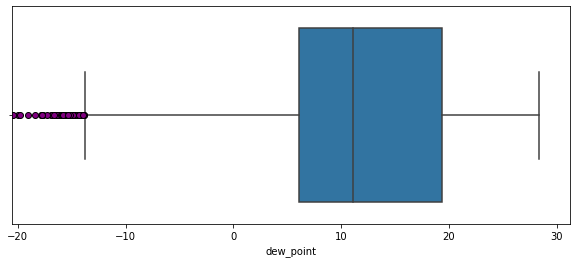

In [ ]:
# visual representation and treatment (now using the train set)
plt.figure(figsize=(10,4))
plt.xlim(data.dew_point.min(), data.dew_point.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=data.dew_point, flierprops=flierprops)

we'll drop it after reconstructing our train and test sets. 

#### Encoding Categorical Columns

In [ ]:
# convert the other objects to datetime
data['sunrise'] = pd.to_datetime(data['sunrise'])
data['sunset'] = pd.to_datetime(data['sunset'])

# extract sunrise and sunset hours
data['sunrise_hour'] = data.sunrise.dt.hour.to_list()
data['set_hour'] = data.sunset.dt.hour.to_list()

# drop sunrise, sunset and updated at - they're of no use to us now.
data = data.drop(['sunrise', 'sunset', 'updated_at', 'datetime_local', 'WeekOfYear'], axis = 1)
print(data.shape)

# check the value counts of the remaining 2 categorical features
categorical = ['icon', 'summary']
for col in categorical:
    print(data[col].value_counts())

(14267, 22)
clear-night            3340
clear-day              3222
fog                    2920
partly-cloudy-day      1832
partly-cloudy-night    1522
cloudy                 1335
rain                     94
wind                      2
Name: icon, dtype: int64
Clear                            6057
Foggy                            2918
Partly Cloudy                    1252
Humid and Mostly Cloudy           828
Humid and Overcast                714
Mostly Cloudy                     691
Overcast                          621
Humid and Partly Cloudy           583
Humid                             505
Possible Light Rain and Humid      52
Possible Light Rain                20
Rain and Humid                     13
Light Rain and Humid                4
Rain                                2
Humid and Foggy                     2
Breezy and Foggy                    2
Light Rain                          1
Possible Drizzle                    1
Possible Drizzle and Humid          1
Name: summary, dt

In [ ]:
# one hot encoding of the categorical columns
data = pd.get_dummies(data, columns = ['summary', 'icon'])
print(data.shape)
data.head()

(14267, 47)


cloud_cover  apparent_temperature  ...  icon_rain  icon_wind
0          0.0                 26.52  ...          0          0
1          0.0                 28.78  ...          0          0
2          0.0                 26.58  ...          0          0
3          0.0                 23.84  ...          0          0
4          0.0                 24.13  ...          0          0

[5 rows x 47 columns]

#### Standardization/Normalisation

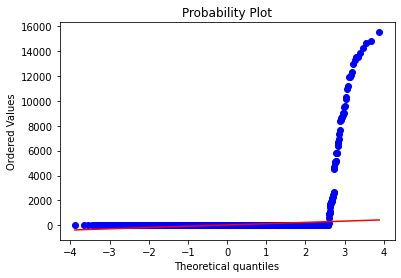

In [ ]:
# target variable
f, ax = plt.subplots(figsize=(7, 6))
sns.distplot(train_target['power'], bins = 5, color = 'purple')
ax.set(ylabel="Frequency")
ax.set(xlabel="power")
ax.set(title="power distribution")

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_target['power'], plot=plt)
plt.show()

Heavily skewed to the right: we do log transformation.

In [ ]:
# log transformation
train_target["power"] = np.log1p(train_target["power"])

[Text(0.5, 1.0, 'power distribution after log transformation')]

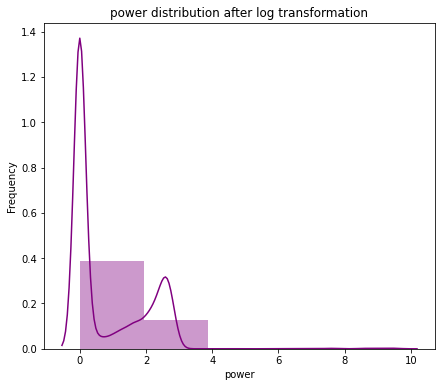

In [ ]:
# target variable
f, ax = plt.subplots(figsize=(7, 6))
sns.distplot(train_target['power'], bins = 5, color = 'purple')
ax.set(ylabel="Frequency")
ax.set(xlabel="power")
ax.set(title="power distribution after log transformation")

Not perfect, but definitely a better representation.

In [ ]:
# standardising the other variables
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data.values)
data = pd.DataFrame(scaled_data, columns = data.columns)
data.head()

cloud_cover  apparent_temperature  ...  icon_rain  icon_wind
0       -0.025              0.050242  ...        0.0        0.0
1       -0.025              0.187046  ...        0.0        0.0
2       -0.025              0.053874  ...        0.0        0.0
3       -0.025             -0.111985  ...        0.0        0.0
4       -0.025             -0.094431  ...        0.0        0.0

[5 rows x 47 columns]

#### Dimensionality Reduction (PCA)

We're doing this to take care of the problem of multicolinearity, and to drop the ohe generated values with predominant 0s.

In [ ]:
type(scaled_data)

numpy.ndarray

In [ ]:
# fitting pca to our standardised data
pca = PCA()
pca = pca.fit(scaled_data)

plt.figure(figsize = (8,6))
plt.plot(range(scaled_data.shape[1]), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('components')
plt.ylabel('cummulative explained variance')
plt.grid(True)

99% of the cariation is caused by arouind 8 - 10 components. 

In [ ]:
pca = PCA(n_components = 10)
pca.fit(scaled_data)
pca_scores = pca.transform(scaled_data)
pca_data = pd.DataFrame(pca_scores)
print(pca_data.shape)
pca_data.head()

(14267, 10)


0         1         2  ...         7         8         9
0  0.252540 -0.492481 -0.602614  ... -0.276799  0.999064 -0.427186
1  0.265466 -0.589005 -0.305437  ...  0.067230  0.970113 -0.211149
2  0.264577 -0.584650 -0.385031  ...  0.118985  0.972132 -0.249468
3  0.249904 -0.478856 -0.812163  ... -0.176947  0.986525 -0.614806
4  0.261836 -0.569750 -0.546115  ...  0.203301  0.972479 -0.252861

[5 rows x 10 columns]

### 4. Model Training, Evaluation and Predictions.

In [ ]:
# reconstructing train and test sets
x = pca_data.iloc[:len(actual)]
y = train_target
x_test = pca_data.iloc[len(actual):]
x.shape, y.shape, x_test.shape

((13619, 10), (13619, 1), (648, 10))

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
model = LinearRegression()
a = cross_val_score(model, x, y, scoring = 'neg_mean_absolute_error')
b = cross_val_score(model, x, y, scoring = 'neg_mean_squared_error')
c = cross_val_score(model, x, y, scoring = 'neg_root_mean_squared_error')
print(f"mean negative mae: {mean(a)}\n mean negative mse: {mean(b)}\n mean negative rmse: {mean(c)}\n")

mean negative mae: -0.6441457403297765
 mean negative mse: -0.8870194751676992
 mean negative rmse: -0.9050824467861079



A very good performance from a very simple model. Now lets use xgb and lgbm with KFolds and observe the performance change.

In [ ]:
model = xgb.XGBRegressor()
a = cross_val_score(model, x, y, scoring = 'neg_mean_absolute_error')
b = cross_val_score(model, x, y, scoring = 'neg_mean_squared_error')
c = cross_val_score(model, x, y, scoring = 'neg_root_mean_squared_error')
print(f"mean negative mae: {mean(a)}\n mean negative mse: {mean(b)}\n mean negative rmse: {mean(c)}\n")

[06:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [363]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()
a = cross_val_score(model, x, y, scoring = 'neg_mean_absolute_error')
b = cross_val_score(model, x, y, scoring = 'neg_mean_squared_error')
c = cross_val_score(model, x, y, scoring = 'neg_root_mean_squared_error')
print(f"mean negative mae: {mean(a)}\n mean negative mse: {mean(b)}\n mean negative rmse: {mean(c)}\n")

mean negative mae: -0.5655822147137318
 mean negative mse: -0.8598953125565767
 mean negative rmse: -0.883375770548356



In [ ]:
# # lgb gridsearchcv (hhyperpatameter tuning)
# folds = KFold(n_splits=5, shuffle=True, random_state=42).split(X=x, y=y)

# param_grid = {
#     'num_leaves': [31, 127],
#     'reg_alpha': [0.1, 0.5],
#     'min_data_in_leaf': [30, 50, 100, 300, 400],
#     'lambda_l1': [0, 1, 1.5],
#     'lambda_l2': [0, 1]
#     }

# lgb_estimator = LGBMRegressor(boosting_type='gbdt', num_boost_round=2000, learning_rate=0.01)

# gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=folds)
# lgb_model = gsearch.fit(X=x, y=y)

# print(lgb_model.best_params_, lgb_model.best_score_)

In [ ]:
# # xgb gridsearch (hyperparameter tuning)
# xgb1 = xgb.XGBRegressor()
# params = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #`eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

# xgb_grid = GridSearchCV(xgb1, params, cv = 5, n_jobs = 5, verbose=True)

# xgb_grid.fit(x, y)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)


In [364]:
# predictions
#lgb
lgb = LGBMRegressor()
lgb = lgb.fit(x, y)
lgb_pred = lgb.predict(x_test)

# xgb
model =  xgb.XGBRegressor()
model = model.fit(x, y)
xgb_pred = model.predict(x_test)

[06:51:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [365]:
# creating a df of the predictions, and doing expm1 to reverse the log transformation
data_dict = {'xgb':np.expm1(xgb_pred), 'lgb':np.expm1(lgb_pred)}
preds_df = pd.DataFrame(data_dict, columns = ['xgb', 'lgb'])
print(preds_df.shape)
preds_df.head()

(648, 2)


xgb       lgb
0  0.139926  0.197301
1  0.144774  0.058866
2  0.134433  0.058866
3  0.121944  0.045707
4  0.202813  0.052132

In [366]:
preds_df['predictions'] = preds_df[['xgb', 'lgb']].mean(axis=1)
preds_df.head()

xgb       lgb  predictions
0  0.139926  0.197301     0.168613
1  0.144774  0.058866     0.101820
2  0.134433  0.058866     0.096650
3  0.121944  0.045707     0.083825
4  0.202813  0.052132     0.127472

In [367]:
predictions = forecast.copy()
predictions['predicted_power'] = preds_df['predictions']
predictions.to_csv('power_predictions.csv')
print(predictions.shape)
predictions.head()

(648, 22)


datetime_local  cloud_cover  ...           updated_at  predicted_power
0  2019-10-01 00:00:00         0.35  ...  2019-10-02 23:32:38         0.168613
1  2019-10-01 01:00:00         0.43  ...  2019-10-02 23:32:38         0.101820
2  2019-10-01 02:00:00         0.48  ...  2019-10-02 23:32:38         0.096650
3  2019-10-01 03:00:00         0.49  ...  2019-10-02 23:32:38         0.083825
4  2019-10-01 04:00:00         0.49  ...  2019-10-02 23:32:38         0.127472

[5 rows x 22 columns]